### A starting notebook for 1D diffusion

The next line activates the environment in which we are working on HW3. It is assumed that you already generated this environment, per the instructions in the document *UsingJulia.pdf*

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/HW3")

"/Users/jeff/Dropbox/MAE250H/julia/development/HW3/Project.toml"

Load some useful packages, including our own!

In [2]:
using Revise
using Plots
using HW3

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/HW3/tjUnr.ji for HW3 [4966e922-5f3d-11e9-0e36-27d9e5a14995]
└ @ Base loading.jl:1184


### Problem statement

The goal of this problem is to solve

$$ \dfrac{\partial u}{\partial t} = \nu \dfrac{\partial^2 u}{\partial x^2}$$

on domain $x \in [0,L]$ subject to boundary conditions $u(0,t) = u_L$ and $u(L,t) = u_R$ and initial condition $u(x,0) = 0$.

### Set up the problem

In [3]:
L = 1  # length of domain
xL = 0.0  # coordinate of left side of domain

0.0

Set physical parameters of the problem

In [4]:
ν = 1
uL = 1
uR = 2

2

Set the spatial discretization and the mapping to physical space

In [5]:
N = 100

100

In [6]:
Δx = L/N
# Note that these are functions, not arrays.
xedge(i_e::Real) = xL + (i_e - 1)*Δx
xcell(i_c::Real) = xL + (i_c - 1.5)*Δx
i_c_int = 2:N+1 # interior cells
i_e = 1:N+1 # edges

1:101

Here we will define functions for use in integrating the problem

In [7]:
# RHS function of diffusion problem for edge data
function diffuse1d_dirichlet(u::HW3.EdgeData1D{N},t::Real) where {N}
    du = HW3.EdgeData1D(u)
    
    # set boundary values to Dirichlet values before applying Laplacian
    u[1] = uL
    u[N+1] = uR
    
    du = HW3.laplacian(u)
    
    return ν/Δx^2*du
end

# RHS function of diffusion problem for cell-centered data
function diffuse1d_dirichlet(u::HW3.CellData1D{N},t::Real) where {N}
    du = HW3.CellData1D(u)
    
    # set ghost cell values to account for Dirichlet values by simple average
    u[1] = -u[2] + 2uL
    u[N+2] = -u[N+1] + 2uR
    
    du = HW3.laplacian(u)
    
    return ν/Δx^2*du
end

# Crank-Nicolson for edge-based data
function diffuse1d_dirichlet_cn(t::Real,u::HW3.EdgeData1D{N}) where {N}
    unp1 = deepcopy(u) # currently hold uⁿ    

    # set the boundary values to zero. We will account for the actual boundary values separately
    u[1] = u[N+1] = 0
    
    Fo = ν*Δt/Δx^2 # grid Fourier number
    
    # unp1 will hold the right-hand side for now
    unp1 .+= 0.5*Fo*HW3.laplacian(u)
    
    # Now account for boundary values
    # It is assumed for now that uL and uR are static
    unp1[2] += 0.5*Fo*(uL + uL) 
    unp1[N] += 0.5*Fo*(uR + uR)
    
    # Set up tridiagonal solve for the N-1 interior edges
    alap = 1
    blap = -2
    clap = 1
    
    a =   -0.5*Fo*alap
    b = 1 -0.5*Fo*blap
    c =   -0.5*Fo*clap
    
    # notice that we are only solving this for the interior edges, and placing
    # the solution in the same vector (replacing the right-hand side there)
    unp1[2:N] .= HW3.trisolve(a,b,c,unp1[2:N],"regular")
    
    # Now place the boundary values in the appropriate places
    unp1[1] = uL
    unp1[N+1] = uR
    
    return t+Δt, unp1
    
end

# Crank-Nicolson for cell-centered data
function diffuse1d_dirichlet_cn(t::Real,u::HW3.CellData1D{N}) where {N}
    unp1 = deepcopy(u) # currently hold uⁿ    

    # set the boundary values to zero. We will account for the actual boundary values separately
    u[1] = u[N+2] = 0
    
    Fo = ν*Δt/Δx^2 # grid Fourier number
    
    # unp1 will hold the right-hand side for now
    unp1 .+= 0.5*Fo*HW3.laplacian(u)
    
    
    # Now account for boundary values, adjusting the Laplacian at the end interior cells
    # due to the averaging, e.g., u[1] = -u[2] + 2uL
    # Also, it is assumed for now that uL and uR are static
    unp1[2]   += Fo*(uL + uL) - 0.5*Fo*u[2]
    unp1[N+1] += Fo*(uR + uR) - 0.5*Fo*u[N+1]
    
    # Set up tridiagonal solve for the N interior cells, using vectors since end values of b are different
    alap = 1*ones(N-1)
    blap = -2*ones(N)
    clap = 1*ones(N-1)
   
    # Adjustment for the Laplacian combined with the averaging (note that 1 and N correspond to cells 2 and N+1)
    blap[1] -= 1
    blap[N] -= 1
    
    a =     -0.5*Fo*alap
    b = 1 .- 0.5*Fo*blap
    c =     -0.5*Fo*clap
    
    # notice that we are only solving this for the interior edges, and placing
    # the solution in the same vector (replacing the right-hand side there)
    unp1[2:N+1] .= HW3.trisolve(a,b,c,unp1[2:N+1],"regular")
    
    # Now place the boundary values in the appropriate places
    unp1[1]   = -unp1[2]   + 2*uL
    unp1[N+2] = -unp1[N+1] + 2*uR
    
    return t+Δt, unp1
    
end

diffuse1d_dirichlet_cn (generic function with 2 methods)

#### Edge-based solution, using RK4

Initial condition

In [8]:
u0 = HW3.EdgeData1D(N);

Steady-state exact solution

In [9]:
uss_edge = HW3.EdgeData1D(u0)
uss_edge[i_e] .= (uR-uL)/L*xedge.(i_e) .+ uL;

Set up time step and integrator

In [10]:
Fo = 0.5 # Fourier number: this choice should be explored!
Δt = Fo*Δx^2/ν 
rk = HW3.RK(u0,Δt,diffuse1d_dirichlet;rk=HW3.RK4)

Order-4 RK integator with
   State of type HW3.EdgeData1D{100}
   Time step size 5.0e-5


### Solve the problem

Integrate this to final time of tf. Try different final times to explore the evolution of the problem.

In [11]:
tf = 0.5
nsteps = ceil(Int,tf/Δt)

# Initial conditions
t = 0.0
u = deepcopy(u0)

# Set up some arrays to store data
uarray = [deepcopy(u)]
tarray = [t]

# March!
for j = 1:nsteps
    t, u = rk(t,u)
    
    # enforce boundary conditions on result
    u[1] = uL
    u[N+1] = uR
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

Plot the result and compare with steady-state exact solution

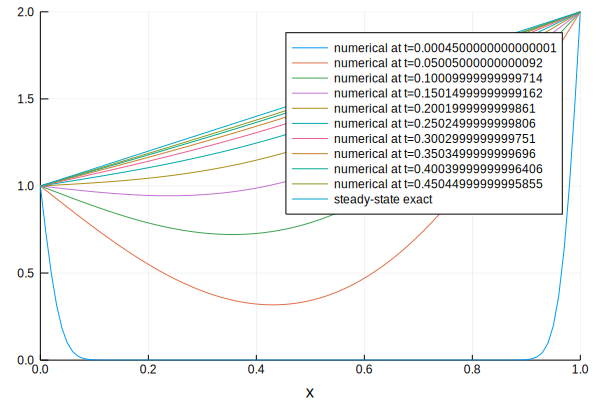

In [12]:
nplot = 10
plot(xedge.(i_e),uarray[10][i_e],xlim=(0,1),ylim=(0,2),label=string("numerical at t=",tarray[10]),xlabel="x")
for j in ceil(Int,length(tarray)/nplot)+1:ceil(Int,length(tarray)/nplot):length(tarray)
    plot!(xedge.(i_e),uarray[j][i_e],xlim=(0,1),ylim=(0,2),label=string("numerical at t=",tarray[j]),xlabel="x")
end
plot!(xedge.(i_e),uss_edge,label="steady-state exact")

#### Try it with cell-centered data and Dirichlet conditions

In [13]:
u0 = HW3.CellData1D(N);

Steady-state exact solution (on interior cells)

In [14]:
uss_cell = HW3.CellData1D(u0)
uss_cell[i_c_int] .= (uR-uL)/L*xcell.(i_c_int) .+ uL;

In [15]:
Δt = 0.5*Δx^2/ν # Fourier number is set to 0.01
rk = HW3.RK(u0,Δt,diffuse1d_dirichlet;rk=HW3.RK4)

Order-4 RK integator with
   State of type HW3.CellData1D{100}
   Time step size 5.0e-5


Integrate this to final time of tf. Again, explore!

In [16]:
tf = 0.5
nsteps = ceil(Int,tf/Δt)
t = 0.0
u = deepcopy(u0)
uarray = [deepcopy(u)]
tarray = [t]
for j = 1:nsteps
    t, u = rk(t,u)
    
    # enforce boundary conditions on result (indirectly, via ghost cells)
    u[1] = 2*uL-u[2]
    u[N+2] = 2*uR-u[N+1]
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

Plot the result and compare with steady-state exact solution

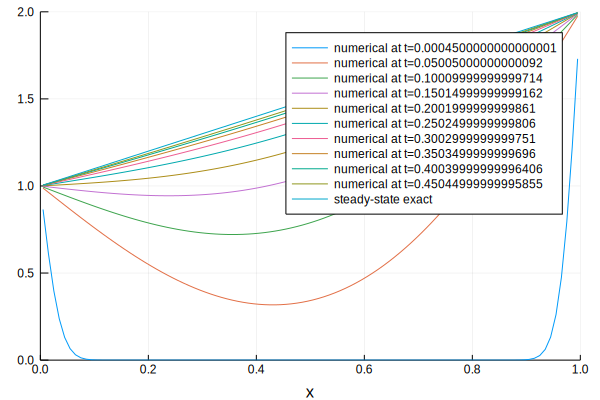

In [17]:
nplot = 10
plot(xcell.(i_c_int),uarray[10][i_c_int],xlim=(0,1),ylim=(0,2),label=string("numerical at t=",tarray[10]),xlabel="x")
for j in ceil(Int,length(tarray)/nplot)+1:ceil(Int,length(tarray)/nplot):length(tarray)
    plot!(xcell.(i_c_int),uarray[j][i_c_int],xlim=(0,1),ylim=(0,2),label=string("numerical at t=",tarray[j]),xlabel="x")
end
plot!(xcell.(i_c_int),uss_cell[i_c_int],label="steady-state exact")

#### Use a semi-implicit time marching method to solve on edges

In [18]:
u0 = HW3.EdgeData1D(N);
#u0 = HW3.CellData1D(N);

Set up time step and integrator

In [19]:
Fo = 1 # Fourier number
Δt = Fo*Δx^2/ν

0.0001

In [20]:
tf = 0.005
nsteps = ceil(Int,tf/Δt)
t = 0.0
u = deepcopy(u0)
uarray = [deepcopy(u)]
tarray = [t]
for j = 1:nsteps
    t, u = diffuse1d_dirichlet_cn(t,u)
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

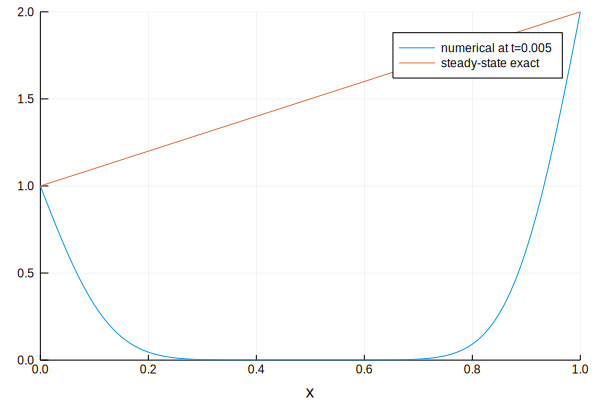

In [21]:
plot(xedge.(i_e),uarray[end][i_e],xlim=(0,1),ylim=(0,2),label=string("numerical at t=",tarray[end]),xlabel="x")
plot!(xedge.(i_e),uss_edge,label="steady-state exact")
#plot(xcell.(i_c_int),uarray[end][i_c_int],xlim=(0,1),ylim=(0,2),label="numerical",xlabel="x")
#plot!(xcell.(i_c_int),uss_cell[i_c_int],label="steady-state exact")